In [77]:
import pandas as pd
import numpy as np
import seaborn as sns


from pandas.plotting import scatter_matrix
from seaborn import scatterplot, heatmap

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import mean_absolute_error

Query: the probability of a customer using a certain payment method depending on age, category, price

In [78]:
df = pd.read_csv("./dataset/customer_shopping_data.csv")

In [79]:
df.dtypes

invoice_no         object
customer_id        object
gender             object
age                 int64
category           object
quantity            int64
price             float64
payment_method     object
invoice_date       object
shopping_mall      object
dtype: object

In [80]:
df.describe(include="all")

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
count,99457,99457,99457,99457.000000,99457,99457.000000,99457.000000,99457,99457,99457
unique,99457,99457,2,NaN,8,NaN,NaN,3,797,10
top,I138884,C241288,Female,NaN,Clothing,NaN,NaN,Cash,24/11/2021,Mall of Istanbul
freq,1,1,59482,NaN,34487,NaN,NaN,44447,159,19943
mean,NaN,NaN,NaN,43.427089,NaN,3.003429,689.256321,NaN,NaN,NaN
std,NaN,NaN,NaN,14.990054,NaN,1.413025,941.184567,NaN,NaN,NaN
min,NaN,NaN,NaN,18.000000,NaN,1.000000,5.230000,NaN,NaN,NaN
25%,NaN,NaN,NaN,30.000000,NaN,2.000000,45.450000,NaN,NaN,NaN
50%,NaN,NaN,NaN,43.000000,NaN,3.000000,203.300000,NaN,NaN,NaN
75%,NaN,NaN,NaN,56.000000,NaN,4.000000,1200.320000,NaN,NaN,NaN


In [81]:
# df = df[['gender','age','category','quantity','price','payment_method','invoice_date','shopping_mall']]

In [82]:
df.columns

Index(['invoice_no', 'customer_id', 'gender', 'age', 'category', 'quantity',
       'price', 'payment_method', 'invoice_date', 'shopping_mall'],
      dtype='object')

In [83]:
df['category'].unique()

array(['Clothing', 'Shoes', 'Books', 'Cosmetics', 'Food & Beverage',
       'Toys', 'Technology', 'Souvenir'], dtype=object)

In [84]:
df['category_num'] = 0
df.loc[df['category'] == 'Clothing', 'category_num'] = 0
df.loc[df['category'] == 'Shoes', 'category_num'] = 1
df.loc[df['category'] == 'Books', 'category_num'] = 2
df.loc[df['category'] == 'Cosmetics', 'category_num'] = 3
df.loc[df['category'] == 'Food & Beverage', 'category_num'] = 4
df.loc[df['category'] == 'Toys', 'category_num'] = 5
df.loc[df['category'] == 'Technology', 'category_num'] = 6
df.loc[df['category'] == 'Souvenir', 'category_num'] = 7

In [85]:
df['payment_method'].unique()

array(['Credit Card', 'Debit Card', 'Cash'], dtype=object)

In [86]:
df['payment_method_num'] = 0
df.loc[df['payment_method'] == 'Credit Card', 'payment_method_num'] = 0
df.loc[df['payment_method'] == 'Debit Card', 'payment_method_num'] = 1
df.loc[df['payment_method'] == 'Cash', 'payment_method_num'] = 2

In [87]:
df['shopping_mall'].unique()

array(['Kanyon', 'Forum Istanbul', 'Metrocity', 'Metropol AVM',
       'Istinye Park', 'Mall of Istanbul', 'Emaar Square Mall',
       'Cevahir AVM', 'Viaport Outlet', 'Zorlu Center'], dtype=object)

In [88]:
df[df['category'] == 'Food & Beverage'].sort_values(by='price',ascending=False)

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,category_num,payment_method_num
33085,I282505,C174327,Female,66,Food & Beverage,5,26.15,Cash,18/06/2021,Metrocity,4,2
77059,I499020,C277687,Female,29,Food & Beverage,5,26.15,Debit Card,22/04/2022,Mall of Istanbul,4,1
76956,I268172,C270215,Female,68,Food & Beverage,5,26.15,Debit Card,13/10/2021,Metropol AVM,4,1
44360,I313479,C224067,Male,67,Food & Beverage,5,26.15,Debit Card,6/1/2021,Mall of Istanbul,4,1
18216,I201848,C866428,Male,44,Food & Beverage,5,26.15,Credit Card,13/10/2022,Metropol AVM,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
39062,I283953,C605123,Female,41,Food & Beverage,1,5.23,Cash,22/07/2021,Mall of Istanbul,4,2
39025,I307197,C649776,Female,45,Food & Beverage,1,5.23,Cash,28/08/2022,Kanyon,4,2
38974,I669438,C155815,Female,37,Food & Beverage,1,5.23,Cash,17/05/2022,Viaport Outlet,4,2
38879,I270477,C323241,Male,50,Food & Beverage,1,5.23,Credit Card,5/3/2023,Emaar Square Mall,4,0


In [89]:
df[df['invoice_no'] == 'I306368']

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,category_num,payment_method_num
10,I306368,C240286,Female,36,Food & Beverage,2,10.46,Cash,25/12/2022,Metrocity,4,2


Istinye - luxury 0
Forum - luxury
Zorlu center - luxury
Kanyon - expensive
Emaar - luxury
Metrocity - luxury
Metropol - medium 1
Mall of Istambul - medium
Viaport - medium
Cevahir - medium 

In [90]:
df['mall_category'] = ''
df.loc[df['shopping_mall'] == 'Kanyon','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Forum Istanbul','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Metrocity','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Metropol AVM','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Istinye Park','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Mall of Istanbul','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Emaar Square Mall','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Cevahir AVM','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Viaport Outlet','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Zorlu Center','mall_category'] = 0

In [91]:
df.describe(include='all')

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,category_num,payment_method_num,mall_category
count,99457,99457,99457,99457.000000,99457,99457.000000,99457.000000,99457,99457,99457,99457.000000,99457.000000,99457.0
unique,99457,99457,2,NaN,8,NaN,NaN,3,797,10,NaN,NaN,2.0
top,I138884,C241288,Female,NaN,Clothing,NaN,NaN,Cash,24/11/2021,Mall of Istanbul,NaN,NaN,0.0
freq,1,1,59482,NaN,34487,NaN,NaN,44447,159,19943,NaN,NaN,59448.0
mean,NaN,NaN,NaN,43.427089,NaN,3.003429,689.256321,NaN,NaN,NaN,2.411042,1.095680,NaN
std,NaN,NaN,NaN,14.990054,NaN,1.413025,941.184567,NaN,NaN,NaN,2.244580,0.888238,NaN
min,NaN,NaN,NaN,18.000000,NaN,1.000000,5.230000,NaN,NaN,NaN,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,30.000000,NaN,2.000000,45.450000,NaN,NaN,NaN,0.000000,0.000000,NaN
50%,NaN,NaN,NaN,43.000000,NaN,3.000000,203.300000,NaN,NaN,NaN,3.000000,1.000000,NaN
75%,NaN,NaN,NaN,56.000000,NaN,4.000000,1200.320000,NaN,NaN,NaN,4.000000,2.000000,NaN


In [92]:
df['gender_num'] = 0
df.loc[df['gender'] == 'Male', 'gender_num'] = 1

In [93]:
dev_df, test_df = train_test_split(df, train_size=0.8, random_state=2)

In [94]:
copy_dev_df = dev_df.copy()

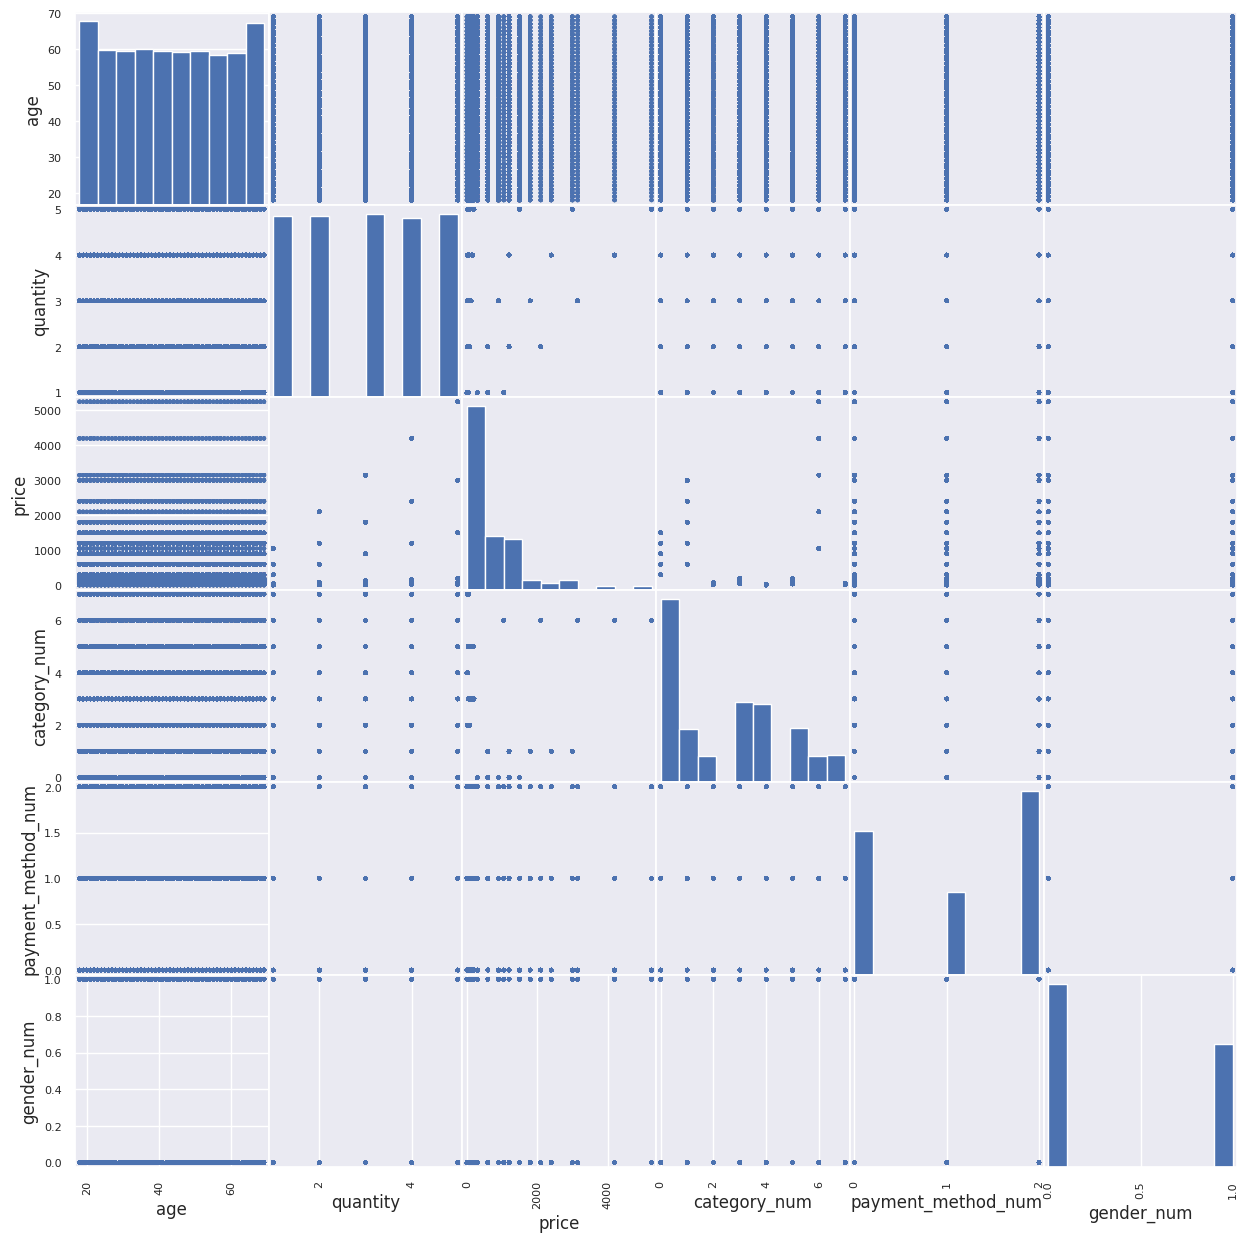

In [95]:
m = scatter_matrix(copy_dev_df,figsize=(15,15))

<Axes: xlabel='payment_method', ylabel='age'>

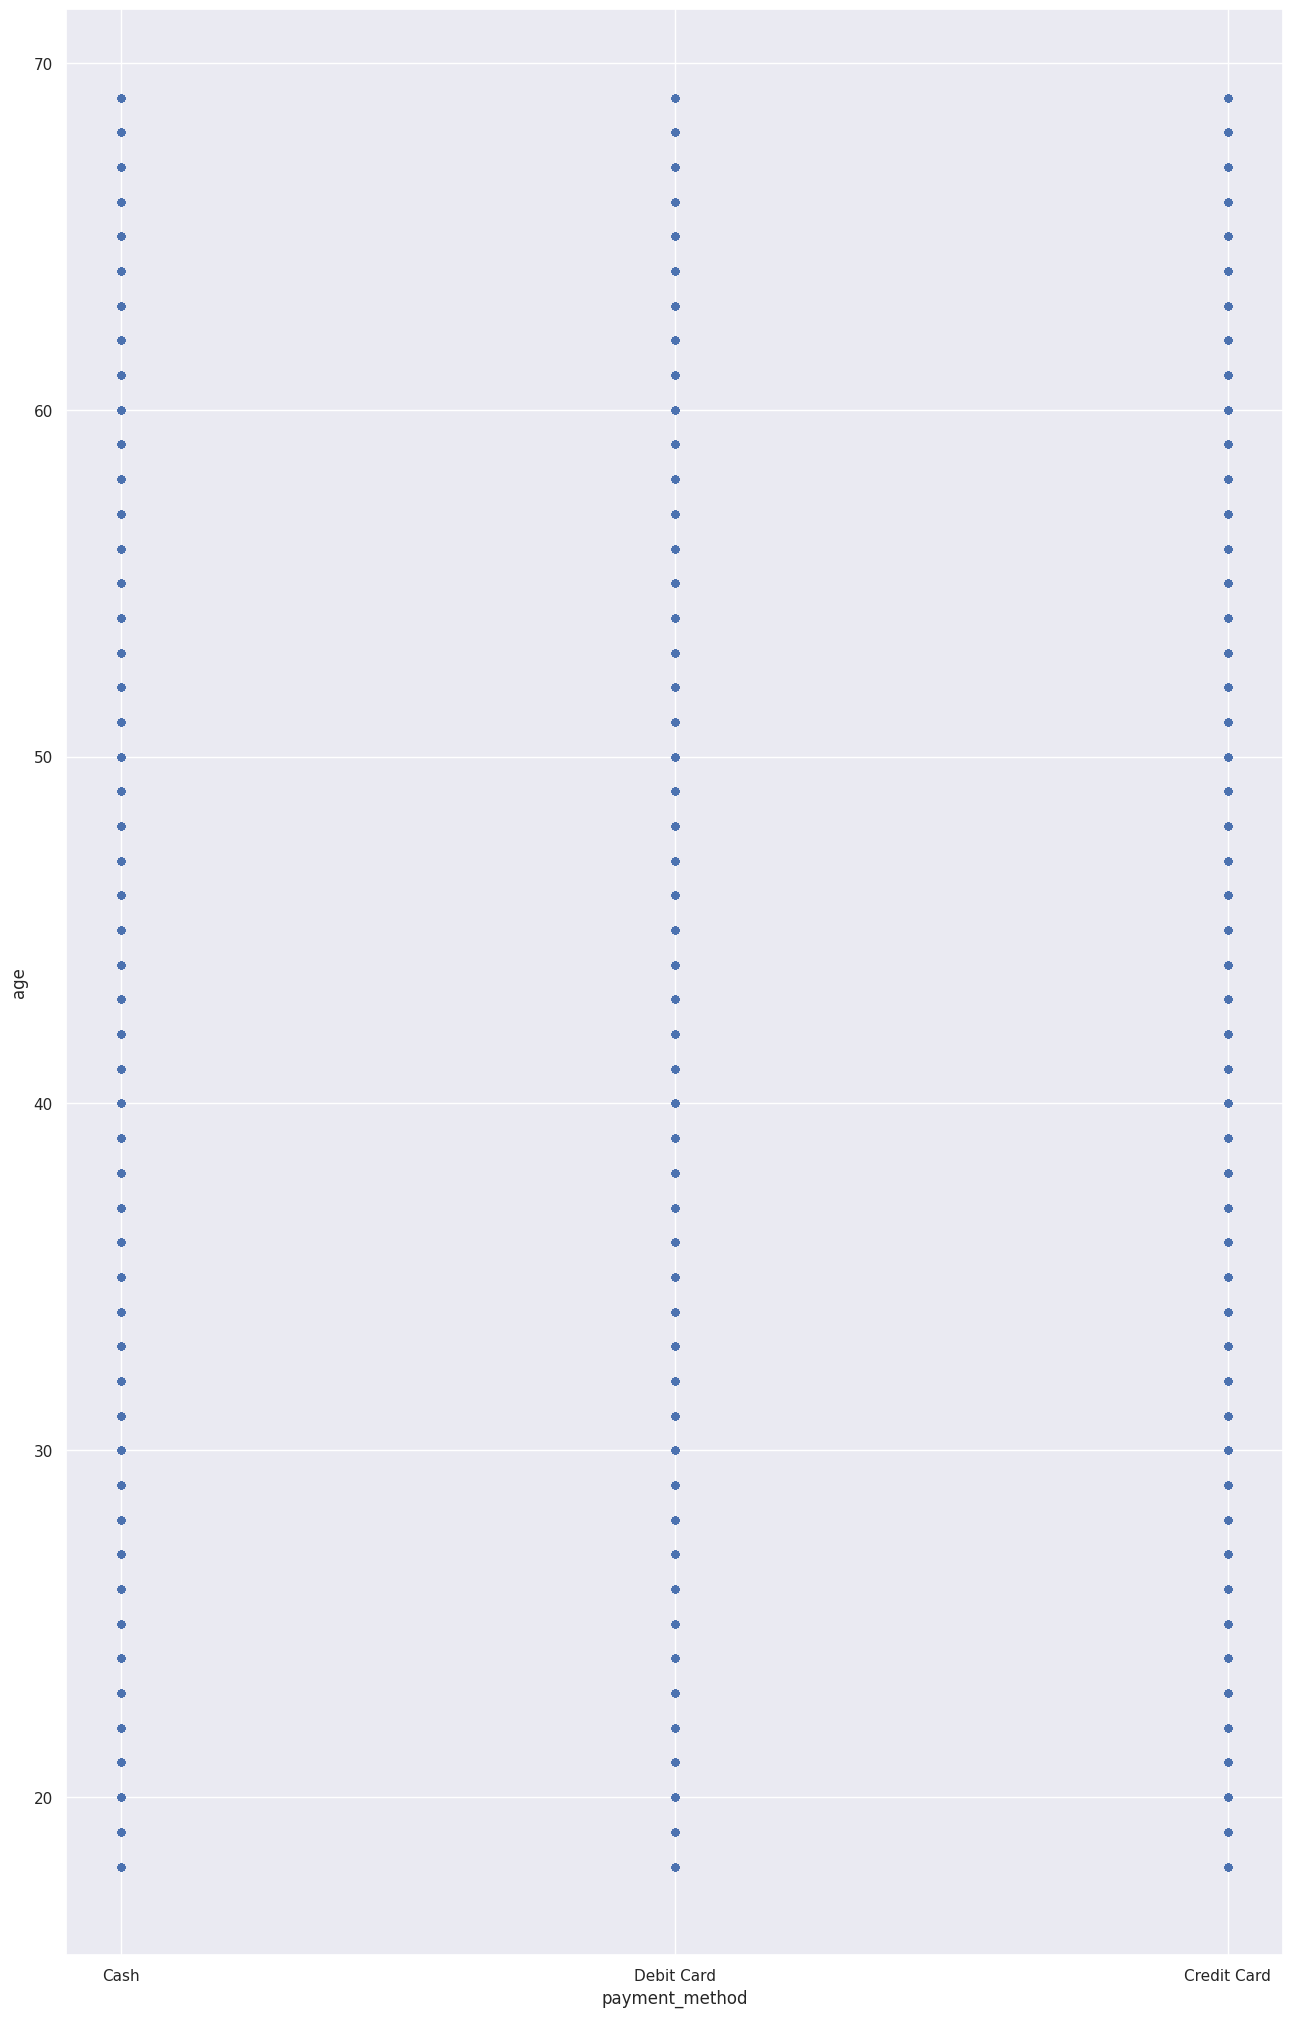

In [96]:
copy_dev_df.plot(kind="scatter", x="payment_method", y="age", alpha=0.1)

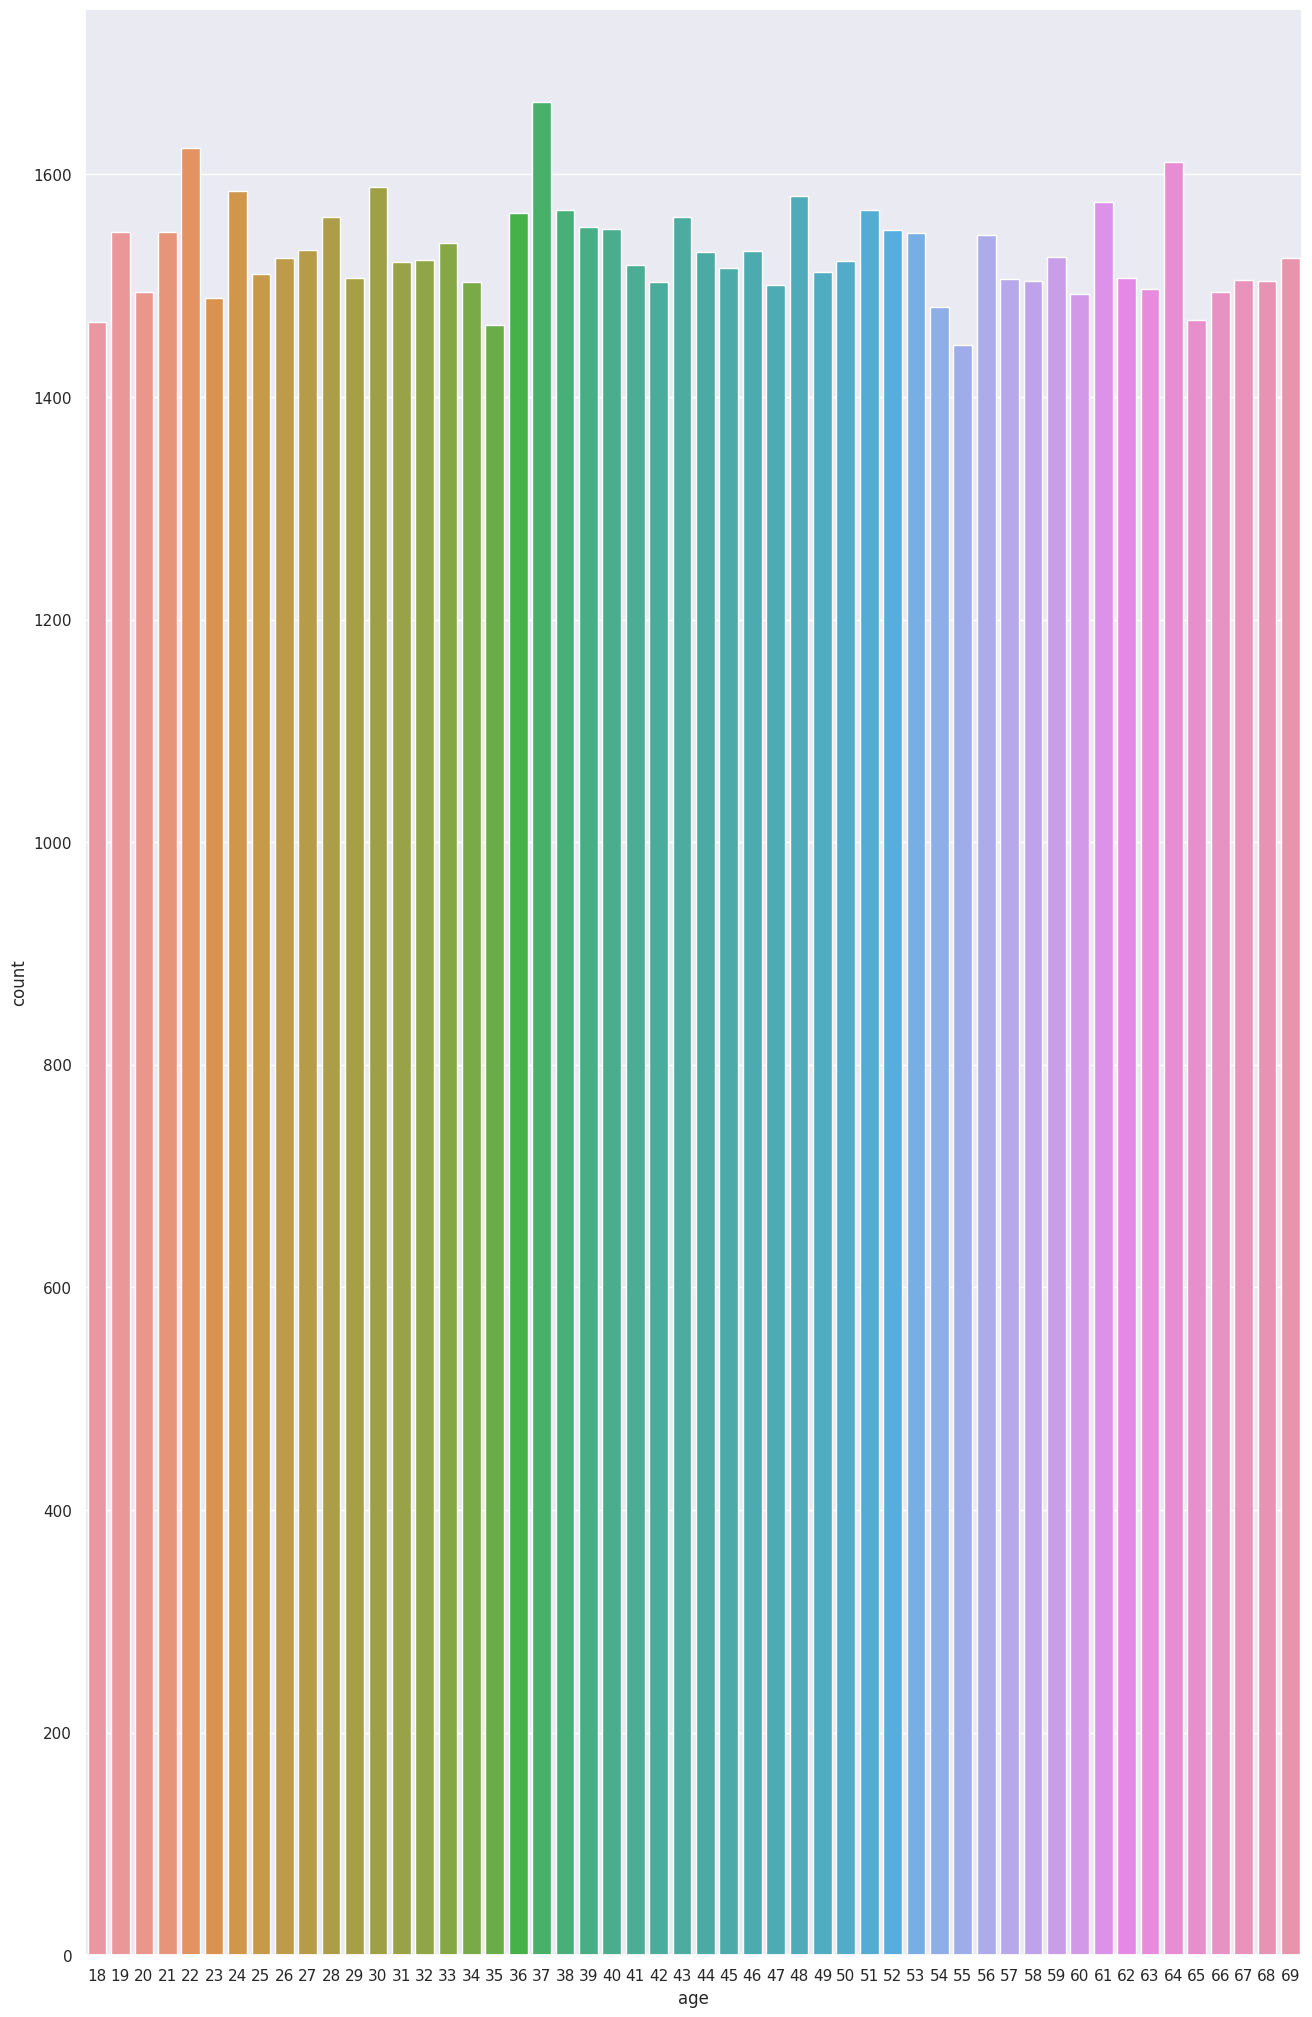

In [97]:
copy_dev_df.sort_values(by='age', ascending=True)
sns.countplot(x = 'age',
              data = copy_dev_df)

sns.set(rc={'figure.figsize':(15.7,25.27)})

Sansele sa cumpere cineva cu card sunt mai mari in jurul sarbatorilor din iarna (black-friday -> Christmas). Diferenta dintre current date si mean of [BF, Xmas].?? major turkish celebrations??

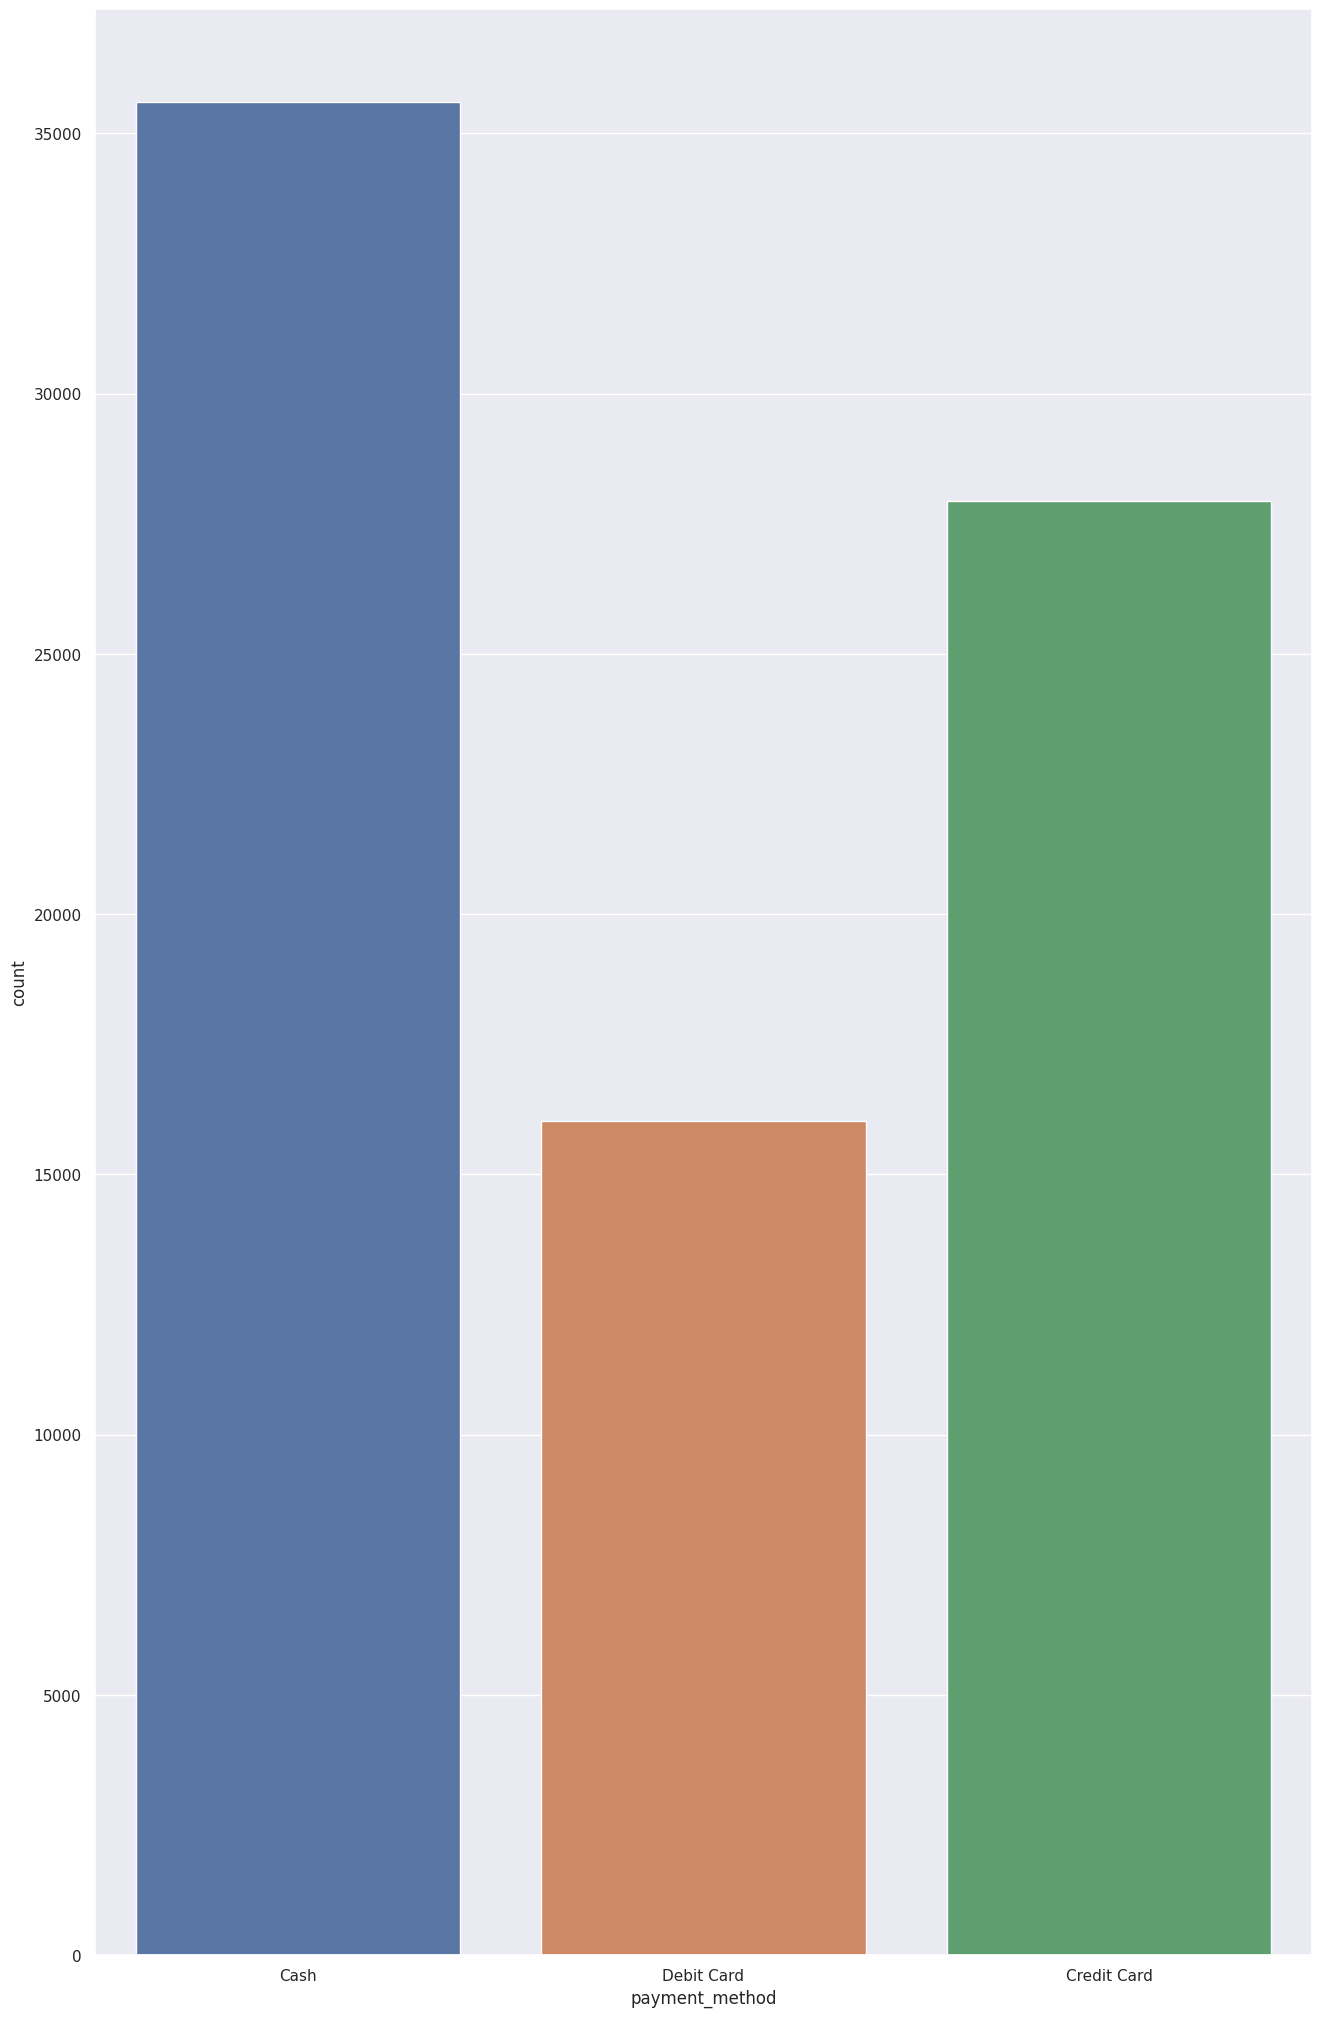

In [99]:
copy_dev_df.sort_values(by='payment_method', ascending=True)
sns.countplot(x = 'payment_method',
              data = copy_dev_df)

sns.set(rc={'figure.figsize':(15.7,25.27)})

<Axes: xlabel='payment_method', ylabel='price'>

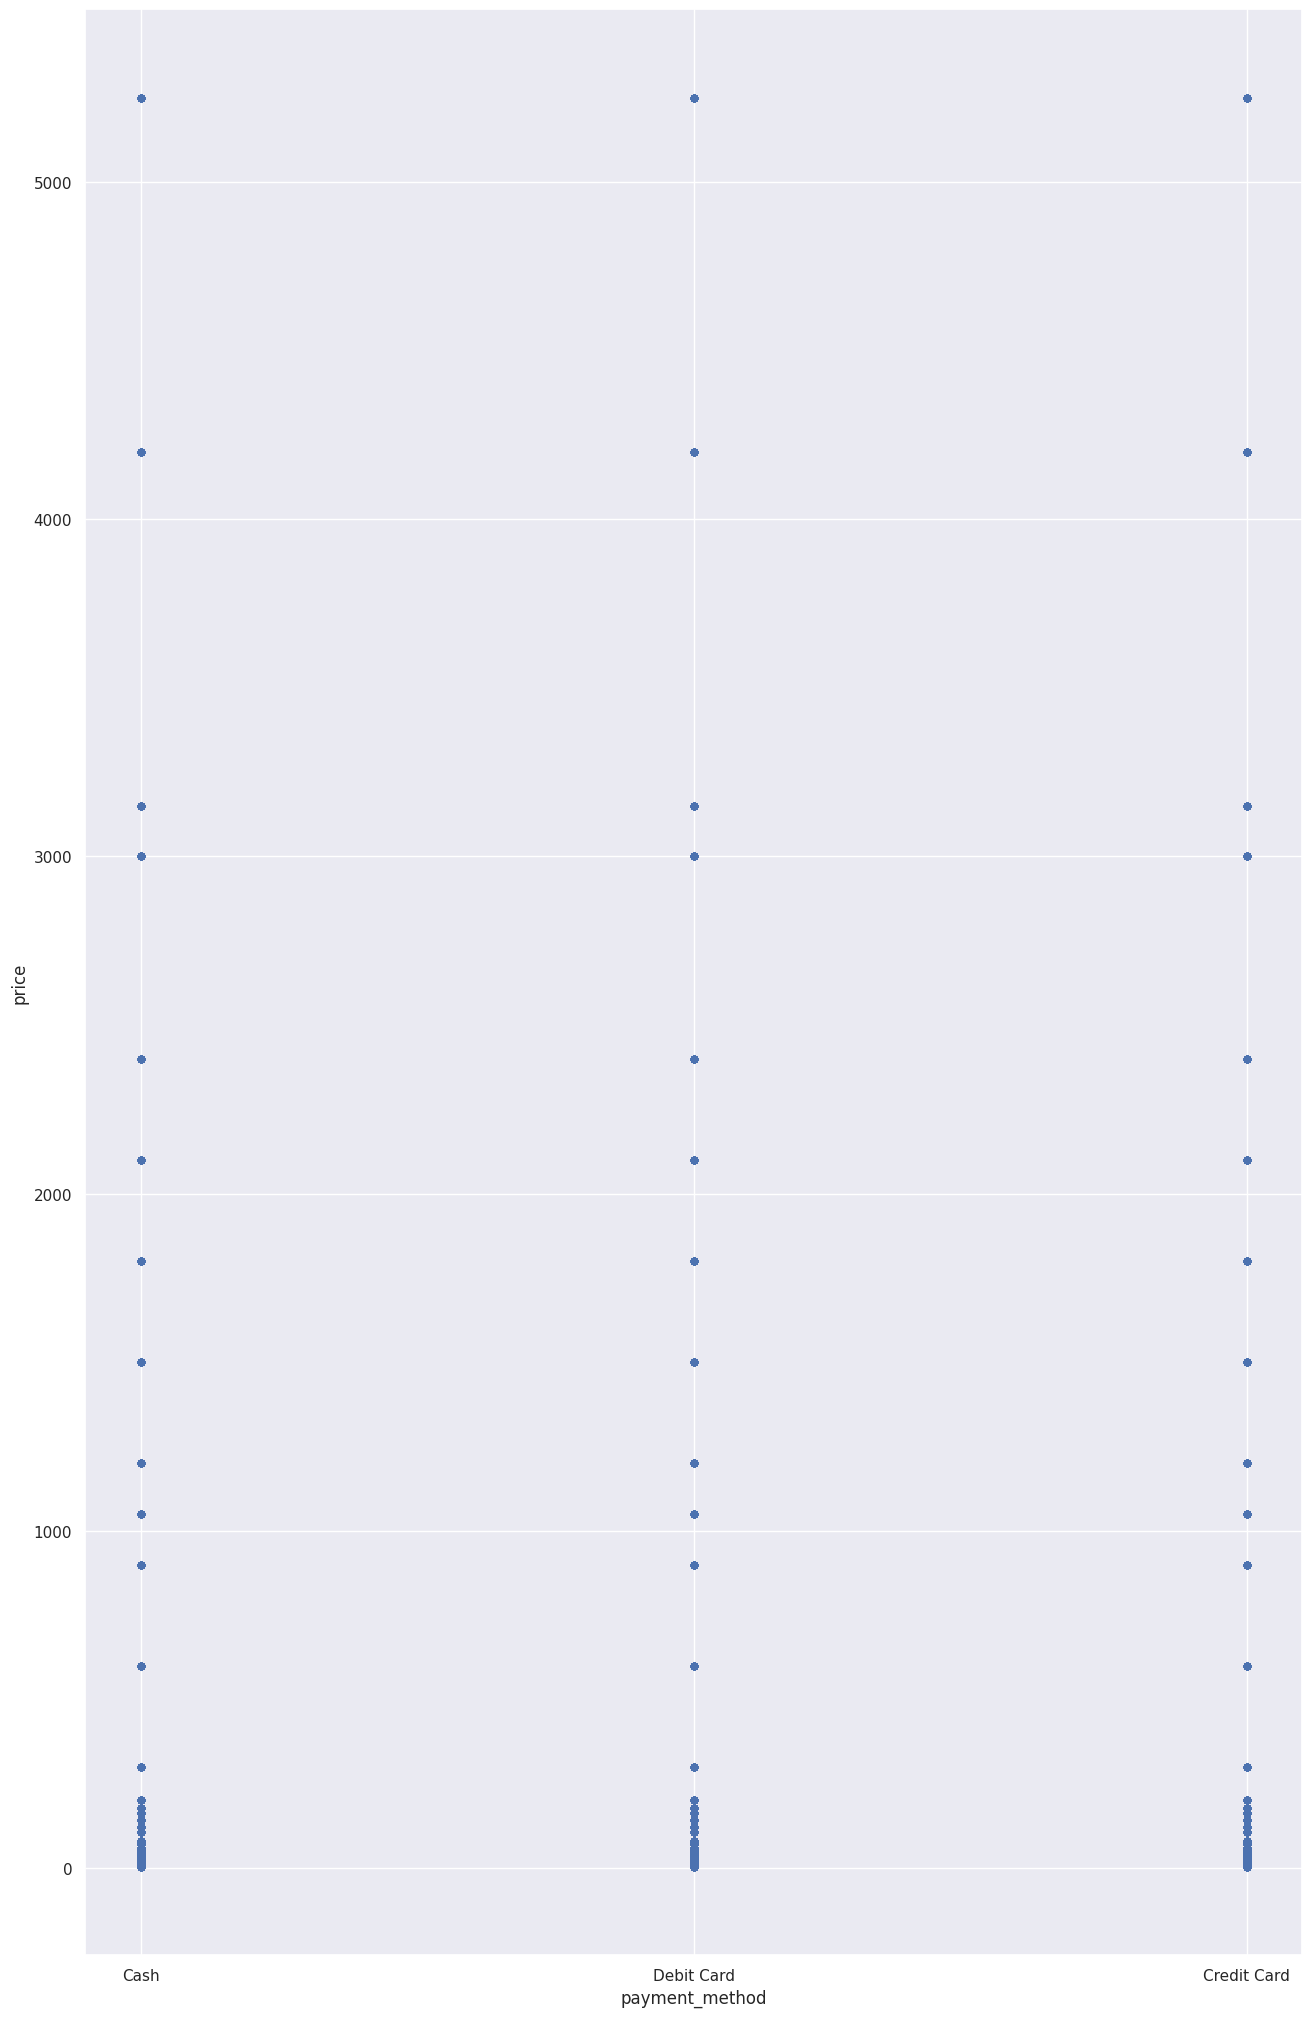

In [101]:
copy_dev_df.plot(kind="scatter", x="payment_method", y="price", alpha=0.1)